# Compare cross-shore changes from CASSIE and CoastSat
(over the 5-year-period available from CoastSat)

**Datasets this notebook expects to find** under the below given datapaths:
- 4 folders, each containing a file `coastlines.shp` (output of Cassie webinterface application):
    - `12_cassie_landsat_1984-04-30_1992-09-04_ext1000_spac5000_base2_multi-thresh/`
    - `13_cassie_landsat_1992-09-20_2003-08-02_ext1000_spac5000_base2_multi-thresh/`
    - `18_cassie_landsat_2003-09-19_2015-03-12_ext1300_spac5000_base1_multi-thresh/`
    - `17_cassie_landsat_2015-04-13_2023-02-22_ext1300_spac5000_base1_multi-thresh/`
- File `image_quality.csv` with the subjective classification of images in usable or not usable for shoreline detection (because of issues with cloud masking in CoastSat)
- File `jarkus_transects_EPSG32631_reduced.geojson` (output of jarkus_shoreline.ipynb, but manually removed overlapping transects in the curvatures with QGIS)
- File `TG_rijkswaterstaat_1992_01_01-2021_12_31.csv` (combined and cleaned individual .csv files from rijkswaterstaat using function `prepare_TG_rijkswaterstaat_data` in the coastal_data module)
- File `transect_red_with_derivatives.nc` (output of jarkus_shoreline.ipynb)

Files that are **created** in this notebook (in case they don't exist):
- `cd_cassie_red.pkl` (uncorrected intersections between shorelines and transects, reduced to the 5-year period from CoastSat)
- `cd_cosat.pkl` (uncorrected intersections between shorelines and transects)
- `beach_slope_cassie_red.pkl` (Variable each slope from JARKUS computed as median over +- 45 m cross-shore buffer zone around the shoreline position)
- `beach_slope_cosat.pkl` (Variable each slope from JARKUS computed as median over +- 45 m cross-shore buffer zone around the shoreline position)

**Required python modules**
- Adjusted [CoastSat](https://github.com/3enedix/CoastSat)
- [coastal_data](https://github.com/3enedix/coastal-sea-level/tree/main/coastal_data)

In [1]:
# Fill in your datapaths
main_datapath_input = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/input/'
main_datapath_output = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/output/'
coastsat_git = '/home/bene/PhD-git/70_CoastSat'

## Imports

In [2]:
%load_ext autoreload
%autoreload 2
import shapefile
import pandas as pd
import numpy as np
import xarray as xr
from scipy import signal
import os
import pickle
from datetime import datetime
import statistics

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec

# toolboxes
import sys
sys.path.append(coastsat_git)
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

from coastal_data import CD_statistics, CD_helper_functions

# projection
from pyproj import CRS, Transformer

import pdb

In [3]:
# matplotlib fontsizes
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
dpi = 300

## Load data

### CASSIE

In [5]:
# Foldernames to the CASSIE shape files
folders = ['12_cassie_landsat_1984-04-30_1992-09-04_ext1000_spac5000_base2_multi-thresh/',\
          '13_cassie_landsat_1992-09-20_2003-08-02_ext1000_spac5000_base2_multi-thresh/',\
          '18_cassie_landsat_2003-09-19_2015-03-12_ext1300_spac5000_base1_multi-thresh/',\
          '17_cassie_landsat_2015-04-13_2023-02-22_ext1300_spac5000_base1_multi-thresh/']
fn = 'coastlines'

# Transformation from EPSG 4326 to EPSG 32631
crs_4326 = CRS.from_epsg(4326)
crs_32631 = CRS.from_epsg(32631)
transformer = Transformer.from_crs(crs_4326, crs_32631)

datelist = []
sllist = []

for folder in folders:
    sf = shapefile.Reader(main_datapath_input + folder + fn)    
    shorelines = sf.shapeRecords().__geo_interface__ # shapefile to geojson
    for sl in shorelines['features']:
        date = pd.to_datetime(sl['properties']['date'], utc=True)
        date = date.to_pydatetime()
        datelist.append(date)

        sl_4326 = sl['geometry']['coordinates']
        sl_23631 = [transformer.transform(_[1], _[0]) for _ in sl_4326]
        sllist_temp = [list(_) for _ in sl_23631]

        sllist.append(np.array(sllist_temp))
        
# put the dates and shoreline coordinates in a dictionary (CoastSat-output-like)
sl_cassie = {'dates' : datelist, 'shorelines' : sllist}

### CoastSat

In [6]:
# region of interest (longitude, latitude)
polygon = [[[5.230406, 53.403205],
            [5.235775, 53.397982],
            [5.328455, 53.411290],
            [5.482734, 53.436546],
            [5.477083, 53.445298],
            [5.272226, 53.412806],
            [5.230406, 53.403205]]]      
polygon = SDS_tools.smallest_rectangle(polygon)
# date range
dates = ['2015-01-01', '2020-01-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['L7','L8','S2']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'

inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'landsat_collection': collection}

In [7]:
with open((main_datapath_input + 'TERS_2015-2019_output.pkl'), 'rb') as f:
    sl_cosat = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
sl_cosat = SDS_tools.remove_duplicates(sl_cosat)
# remove inaccurate georeferencing (set threshold to 10 m)
sl_cosat = SDS_tools.remove_inaccurate_georef(sl_cosat, 10)

49 duplicates
33 bad georef


#### Manually remove bad shorelines using their dates

In [8]:
def remove_bad_shorelines(sds, dates_bad_list):
    # round to dates to make them comparable
    dates_bad = [_.date() for _ in dates_bad_list]
    dates_all = [_.date() for _ in sds["dates"]]
    
    output_cleaned = dict()
    
    # find indices of bad dates
    idx = []
    for date_bad in dates_bad:
        try: # not all dates_bad are also in dates_all after removing duplicates and bad georef
            idx.append(dates_all.index(date_bad))
        except:
            continue
    # keep only the good ones
    output_cleaned = dict()    
    for key in sds:
        list_temp = []
        for i in range(0, len(sds[key])):
            if i not in idx:
                list_temp.append(sds[key][i])
        output_cleaned[key] = list_temp
    return output_cleaned

In [9]:
dates_np = pd.read_csv(main_datapath_input + 'image_quality.csv', header = 2, names=['C1', 'C2', 'C3', 'C4'], parse_dates=[0,1,2,3])

# C1: Cloud cover makes image unusable (or detection fails)
# C2: Part of the image is usable, could profit from cloud masking
# C3: There is a good coastline detected, but also other features are declared as coastlines
# C4: Good

# DataFrame columns to array
dates_np_arr = np.concatenate((dates_np['C1'].values, dates_np['C2'].values))
nan_idx = np.where(np.isnan(dates_np_arr))
dates_np_arr = np.delete(dates_np_arr, nan_idx)

unix_epoch = np.datetime64(0, 's')
one_second = np.timedelta64(1, 's')
seconds_since_epoch = (dates_np_arr - unix_epoch) / one_second

dates_bad_list = [datetime.utcfromtimestamp(_) for _ in seconds_since_epoch]

In [10]:
# for some reason the function must be executed twice
sl_cosat = remove_bad_shorelines(sl_cosat, dates_bad_list)
sl_cosat = remove_bad_shorelines(sl_cosat, dates_bad_list)

### Reduce Cassie to CoastSat period

In [11]:
idx = np.nonzero([_ in sl_cosat['dates'] for _ in sl_cassie['dates']])[0]
sl_cassie['dates'] = np.array(sl_cassie['dates'])[idx]
sl_cassie['shorelines'] = np.array(sl_cassie['shorelines'])[idx]

<ipython-input-11-d19848ca0607>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sl_cassie['shorelines'] = np.array(sl_cassie['shorelines'])[idx]


## Load transects

In [12]:
# JARKUS-transects:
fn = 'jarkus_transects_EPSG32631_reduced.geojson'
geojson_file = main_datapath_output + fn
transects = SDS_tools.transects_from_geojson(geojson_file)

152 transects have been loaded


## Settings for timeseries

In [13]:
settings_ts = { # parameters for analysis of cross-shore time series
    # intersection computation
    'along_dist': 1200,    # along-shore distance to use for computing the intersection
    'type_intersection_computation': 'qc', # 'non_qc': not quality controled, 'qc': quality controled
    # smoothing
    'type_smoothing': 'moving_average', # 'moving_average' or 'savgol'
    'sm_window_size' : 5, # window size for smoothing
    'polyorder' : 3, # order of the polynomial for savitzky golay filter
    # tidal correction
    'beach_slope' : 'variable_median', # 'uniform', 'variable_median' or 'variable_mean'
    'grad_buffer' : 45, # [m], 1/2 length of the zone where the gradients in each point are considered for mean or median
    'water_levels_source' : 'tg', #'tg' or 'eot'
    'tide_corr_thresh' : 100, # [m], threshold for maximum tidal correction     
                    }

## Compute intersections

In [14]:
if (not os.path.isfile(main_datapath_output+'cd_cassie_red.pkl')) | (not os.path.isfile(main_datapath_output+'cd_cosat.pkl')):
    if settings_ts['type_intersection_computation'] == 'non_qc':
        settings_transects = {
            'along_dist': settings_ts['along_dist'],     # along-shore distance to use for computing the intersection
            'max_dist_origin': 10000,     # maximum distance to the origin of a transect in [m]
                         }
        cd_cassie = SDS_transects.compute_intersection(sl_cassie, transects, settings_transects)
        cd_cosat = SDS_transects.compute_intersection(sl_cosat, transects, settings_transects)
    elif settings_ts['type_intersection_computation'] == 'qc':
        settings_transects = { # parameters for computing intersections
                      'along_dist': settings_ts['along_dist'],    # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':             0.1,      # percentage of the time that multiple intersects are present to use the max
                      'max_dist_origin':      10000,     # maximum distance to the origin of a transect in [m]
                    }
        cd_cassie = SDS_transects.compute_intersection_QC(sl_cassie, transects, settings_transects)
        cd_cosat = SDS_transects.compute_intersection_QC(sl_cosat, transects, settings_transects)
                
        # Interpolate over the nans
        for key in cd_cassie.keys():
            cd_cassie[key] = np.array(pd.Series(cd_cassie[key]).interpolate())
        for key in cd_cosat.keys():
            cd_cosat[key] = np.array(pd.Series(cd_cosat[key]).interpolate())
            
        # Smoothing
        if settings_ts['type_smoothing'] == 'moving_average':
            cd_cassie_sm = {}
            for key in cd_cassie.keys():
                cd_cassie_sm[key] = CD_statistics.moving_average(cd_cassie[key], settings_ts['sm_window_size'])

            cd_cosat_sm = {}
            for key in cd_cosat.keys():
                cd_cosat_sm[key] = CD_statistics.moving_average(cd_cosat[key], settings_ts['sm_window_size'])

        elif settings_ts['type_smoothing'] == 'savgol':
            # Savitzky-Golay filter
            cd_cassie_sm = {}
            for key in cd_cassie.keys():
                cd_cassie_sm[key] = signal.savgol_filter(cd_cassie[key], settings_ts['sm_window_size'], settings_ts['polyorder'])

            cd_cosat_sm = {}
            for key in cross_distance.keys():
                cd_cosat_sm[key] = signal.savgol_filter(cd_cosat[key], settings_ts['sm_window_size'], settings_ts['polyorder'])
            
        pickle.dump(cd_cassie_sm, open(main_datapath_output+'cd_cassie_red.pkl', 'wb'))
        pickle.dump(cd_cosat_sm, open(main_datapath_output+'cd_cosat.pkl', 'wb'))
else:
    cd_cassie_sm = pickle.load(open(main_datapath_output+'cd_cassie_red.pkl', 'rb'))
    cd_cosat_sm = pickle.load(open(main_datapath_output+'cd_cosat.pkl', 'rb'))

### Reduce Cassie to the CoastSat transects

In [15]:
# delete all only-nan transects
for transect in transects.keys():
    if np.all(np.isnan(cd_cosat_sm[transect])):
        cd_cosat_sm.pop(transect, None);
    if np.all(np.isnan(cd_cassie_sm[transect])):
        cd_cassie_sm.pop(transect, None);

# reduce cassie
cd_cassie_sm_red = {}
for transect in cd_cassie_sm.keys():
    if transect in cd_cosat_sm.keys():
        cd_cassie_sm_red[transect] = cd_cassie_sm[transect]
cd_cassie_sm = cd_cassie_sm_red

## Tidal correction

### Water levels

In [16]:
# get tide gauge data (North Sea)
data = pd.read_csv(main_datapath_input + 'TG_rijkswaterstaat_1992_01_01-2021_12_31.csv', index_col='datetime[utc]', \
                  parse_dates=['datetime[utc]'])
tides_ts = np.array(data['ssh[cm]']) / 100 # [m]

dates_ts = CD_helper_functions.datetime_to_decimal_numbers(data.index)
dates_cassie = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cassie['dates']))
dates_cosat = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cosat['dates']))

# reduce SDS-timeseries to the timespan where tide gauge data is available
idx_tides_cassie = np.where((np.array(dates_cassie) < dates_ts[-1]) & (np.array(dates_cassie) > dates_ts[0]))[0]
dates_cassie = dates_cassie[idx_tides_cassie]

idx_tides_cosat = np.where((np.array(dates_cosat) < dates_ts[-1]) & (np.array(dates_cosat) > dates_ts[0]))[0]
dates_cosat = np.array(dates_cosat)[idx_tides_cosat]

tides_cassie = np.interp(dates_cassie, dates_ts, tides_ts)
tides_cosat = np.interp(dates_cosat, dates_ts, tides_ts)

In [17]:
# reduce cross_distance and sl_dict to the timespan where tide data is available
cd_cassie_red_tides = {}
for key in cd_cassie_sm.keys():
    cd_cassie_red_tides[key] = cd_cassie_sm[key][idx_tides_cassie]
    
cd_cosat_red_tides = {}
for key in cd_cosat_sm.keys():
    cd_cosat_red_tides[key] = cd_cosat_sm[key][idx_tides_cosat]

# sl_dict_red_tides
sl_cassie_red_tides = {}
sl_cassie_red_tides['dates'] = np.array(sl_cassie['dates'], dtype=object)[idx_tides_cassie]
sl_cassie_red_tides['shorelines'] = np.array(sl_cassie['shorelines'], dtype=object)[idx_tides_cassie]

sl_cosat_red_tides = {}
sl_cosat_red_tides['dates'] = np.array(sl_cosat['dates'], dtype=object)[idx_tides_cosat]
sl_cosat_red_tides['shorelines'] = np.array(sl_cosat['shorelines'], dtype=object)[idx_tides_cosat]

### Variable beach slope

In [18]:
def compute_variable_beach_slope(jarkus_data, sl_red_tides, cd_red_tides):
    # 1. For each sl_dict-date, find the corresponding time-index in jarkus
    sl_years = [_.year for _ in sl_red_tides['dates']]
    jarkus_years = [pd.to_datetime(_.values).year for _ in jarkus_data.time]
    # idx: which jarkus-gradient belongs to which shoreline in sl_dict
    idx_time = [jarkus_years.index(_) for _ in sl_years]

    beach_slope = {}
    for key in cd_red_tides.keys():
        # 2. Relate cross_distance coordinate system to jarkus.cross_shore
        sl_cross = cd_red_tides[key] - 3000

        # 3. Buffer around the shoreline position for each point in time
        bnd_sea = sl_cross + settings_ts['grad_buffer']
        bnd_land = sl_cross - settings_ts['grad_buffer']
        # for each point in time, there is one cross-shore distance
        # bnd_sea/land define the maximum seaward/landward point along the profile to take into account for each point in time

        # 4. Get the gradients in the buffer zone
        # get the respective transect
        idx_along = np.where(jarkus_data.id == int(key))[0][0]

        # filter the dataset for transect and time
        grad = jarkus_data.altitude_red_1st_derivative[idx_time, idx_along, :]
        if np.all(np.isnan(grad)):
            beach_slope[key] = np.nan
            continue
        # checked for transect '4002880', all altitude variables are nan (not only the _red ones)

        # compute mean/median       
        if settings_ts['beach_slope'] == 'variable_mean':
            grad_mean = [] # mean gradient
            for t in range(0, len(grad.time)):
                idx_cross = np.where((grad.cross_shore <= bnd_sea[t]) & (grad.cross_shore >= bnd_land[t]))[0]
                grad_mean_temp = grad[t, idx_cross].mean().values
                grad_mean.append(round(float(grad_mean_temp), 3))
            # Interpolate over the nans
            grad_mean = pd.Series(grad_mean).interpolate().tolist()
            beach_slope[key] = grad_mean
        elif settings_ts['beach_slope'] == 'variable_median':
            grad_median = [] # median gradient        
            for t in range(0, len(grad.time)):
                idx_cross = np.where((grad.cross_shore <= bnd_sea[t]) & (grad.cross_shore >= bnd_land[t]))[0]
                grad_median_temp = grad[t, idx_cross].median().values
                grad_median.append(round(float(grad_median_temp), 3))
            # Interpolate over the nans
            grad_median = pd.Series(grad_median).interpolate().tolist()
            beach_slope[key] = grad_median
        elif settings_ts['beach_slope'] != str: # uniform beach slope
            beach_slope[key] = settings_ts['beach_slope']
            
    return beach_slope    

In [19]:
if (not os.path.isfile(main_datapath_output+'beach_slope_cosat.pkl')) | (not os.path.isfile(main_datapath_output+'beach_slope_cassie_red.pkl')):
    jarkus_data = xr.open_dataset(main_datapath_output + 'transect_red_with_derivatives.nc', engine='netcdf4')

    beach_slope_cassie = compute_variable_beach_slope(jarkus_data, sl_cassie_red_tides, cd_cassie_red_tides)
    beach_slope_cosat = compute_variable_beach_slope(jarkus_data, sl_cosat_red_tides, cd_cosat_red_tides)

    pickle.dump(beach_slope_cassie, open(main_datapath_output+'beach_slope_cassie_red.pkl', 'wb'))
    pickle.dump(beach_slope_cosat, open(main_datapath_output+'beach_slope_cosat.pkl', 'wb'))
else:
    beach_slope_cassie = pickle.load(open(main_datapath_output+'beach_slope_cassie_red.pkl', 'rb'))
    beach_slope_cosat = pickle.load(open(main_datapath_output+'beach_slope_cosat.pkl', 'rb'))

### Correction

In [20]:
def compute_and_apply_correction(cd_red_tides, tides, beach_slope):
    reference_elevation = 0
    thresh_pos = settings_ts['tide_corr_thresh'] # [m] threshold the corrections to eliminate outliers
    thresh_neg = -thresh_pos
    
    cd_tidalcorr = {}
    for key in cd_red_tides.keys():
        corr = (tides - reference_elevation) / beach_slope[key]
        corr[corr > thresh_pos] = thresh_pos
        corr[corr < thresh_neg] = thresh_neg
        cd_tidalcorr[key] = cd_red_tides[key] - corr       
        
    # Smoothing
    cd_tidalcorr_sm = {}
    if settings_ts['type_smoothing'] == 'moving_average':
        for key in cd_tidalcorr.keys():
            cd_tidalcorr_sm[key] = CD_statistics.moving_average(cd_tidalcorr[key], settings_ts['sm_window_size'])
    elif settings_ts['type_smoothing'] == 'savgol':
        for key in cd_tidalcorr.keys():
            cd_tidalcorr_sm[key] = signal.savgol_filter(cd_tidalcorr[key], settings_ts['sm_window_size'], settings_ts['polyorder'])
    
    return cd_tidalcorr_sm

In [21]:
cd_cassie_tidalcorr_sm = compute_and_apply_correction(cd_cassie_red_tides, tides_cassie, beach_slope_cassie)
cd_cosat_tidalcorr_sm = compute_and_apply_correction(cd_cosat_red_tides, tides_cosat, beach_slope_cosat)

### Plots

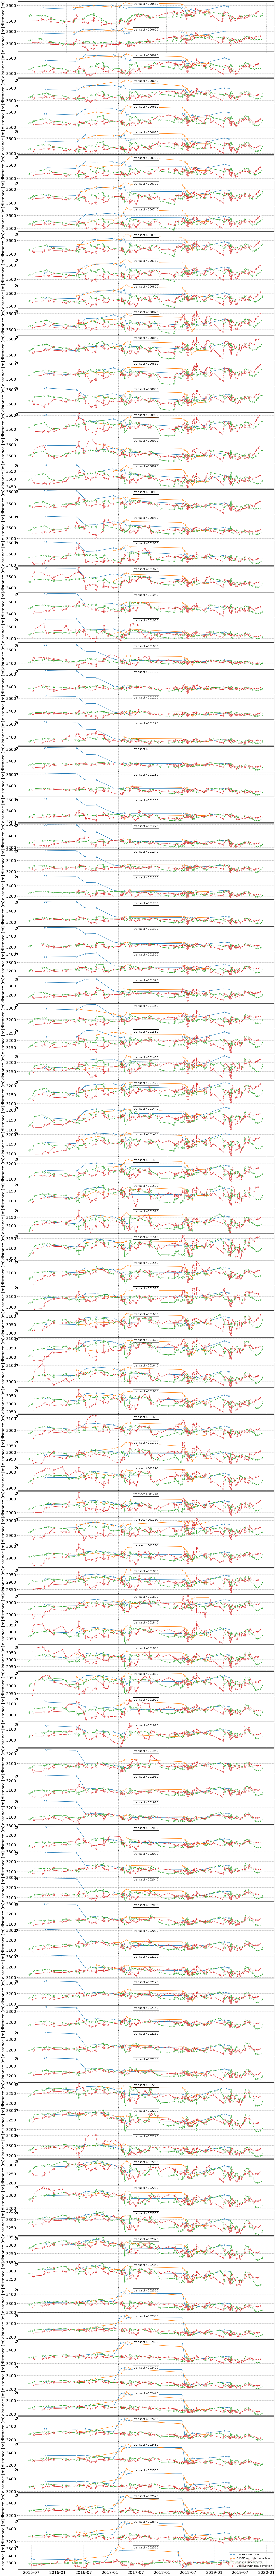

In [22]:
# plot timeseries for all transects
fig = plt.figure(figsize=[20,200])
gs = gridspec.GridSpec(len(cd_cassie_sm),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cd_cassie_sm.keys()):
    if np.all(np.isnan(cd_cassie_sm[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    
    ax.plot(sl_cassie['dates'], cd_cassie_sm[key], '-o', ms=6, mfc='w', label='CASSIE uncorrected')
    ax.plot(sl_cassie_red_tides['dates'], cd_cassie_tidalcorr_sm[key], '-o', ms=6, mfc='w', label='CASSIE with tidal correction')
    ax.plot(sl_cosat['dates'], cd_cosat_sm[key], '-o', ms=6, mfc='w', label='CoastSat uncorrected')
    ax.plot(sl_cosat_red_tides['dates'], cd_cosat_tidalcorr_sm[key], '-o', ms=6, mfc='w', label='CoastSat with tidal correction')
    
    ax.set_ylabel('distance [m]')
    ax.set_ylabel('distance [m]')
    ax.text(0.5,0.95, 'transect ' + key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center', va='top', transform=ax.transAxes, fontsize=14)
ax.legend(loc='lower right', fontsize='large');

## Comparison
- Std, trend per transect (could also be a map), with and without tidal correction
- Correlation
- Absolute differences (histogram)

### Standard deviation

In [23]:
std_cassie, std_cassie_tcorr, std_cosat, std_cosat_tcorr = [], [], [], []
for transect in cd_cassie_sm.keys():
    std_cassie.append(CD_statistics.std(cd_cassie_sm[transect]))
    std_cassie_tcorr.append(CD_statistics.std(cd_cassie_tidalcorr_sm[transect]))
    std_cosat.append(CD_statistics.std(cd_cosat_sm[transect]))
    std_cosat_tcorr.append(CD_statistics.std(cd_cosat_tidalcorr_sm[transect]))

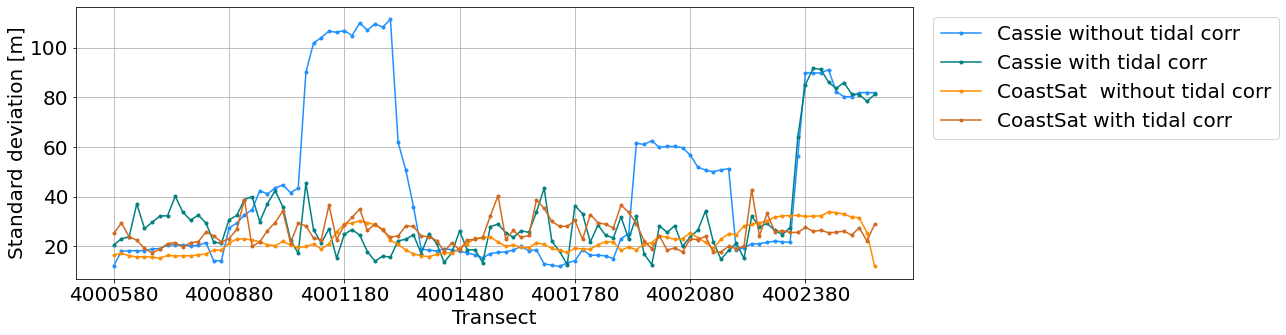

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cd_cassie_sm.keys(), std_cassie, '.-', label='Cassie without tidal corr', color='dodgerblue')
ax.plot(cd_cassie_sm.keys(), std_cassie_tcorr, '.-', label='Cassie with tidal corr', color='teal')
ax.plot(cd_cosat_sm.keys(), std_cosat, '.-', label='CoastSat  without tidal corr', color='darkorange')
ax.plot(cd_cosat_sm.keys(), std_cosat_tcorr, '.-', label='CoastSat with tidal corr', color='chocolate')
ax.legend(bbox_to_anchor=(0.95, 0.5, 0.5, 0.5))
ax.set_ylabel('Standard deviation [m]')
ax.set_xlabel('Transect')
xticks = list(cd_cassie_sm.keys())[0::15]
ax.set_xticks(xticks)
ax.grid()

### Trend

In [25]:
# time vectors
x_cassie = []
for date in sl_cassie_red_tides['dates']:
    x_cassie.append(CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(date)))
x_cosat = []
for date in sl_cosat_red_tides['dates']:
    x_cosat.append(CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(date)))

trend_cassie, trend_cassie_tcorr, trend_cosat, trend_cosat_tcorr = [], [], [], []
for transect in cd_cassie_sm.keys():
    trend_cassie.append(CD_statistics.compute_trend(x_cassie, cd_cassie_sm[transect]))
    trend_cassie_tcorr.append(CD_statistics.compute_trend(x_cassie, cd_cassie_tidalcorr_sm[transect]))
    trend_cosat.append(CD_statistics.compute_trend(x_cosat, cd_cosat_sm[transect]))
    trend_cosat_tcorr.append(CD_statistics.compute_trend(x_cosat, cd_cosat_tidalcorr_sm[transect]))

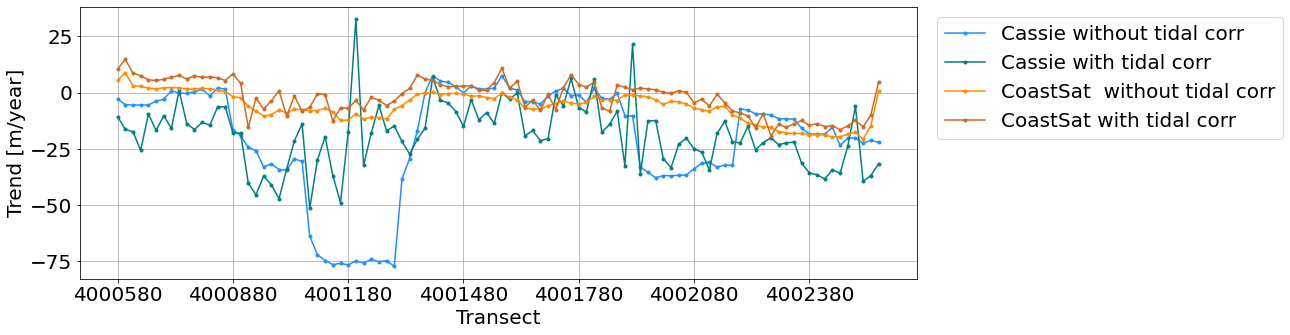

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cd_cassie_sm.keys(), trend_cassie, '.-', label='Cassie without tidal corr', color='dodgerblue')
ax.plot(cd_cassie_sm.keys(), trend_cassie_tcorr, '.-', label='Cassie with tidal corr', color='teal')
ax.plot(cd_cosat_sm.keys(), trend_cosat, '.-', label='CoastSat  without tidal corr', color='darkorange')
ax.plot(cd_cosat_sm.keys(), trend_cosat_tcorr, '.-', label='CoastSat with tidal corr', color='chocolate')
ax.legend(bbox_to_anchor=(0.95, 0.5, 0.5, 0.5))
ax.set_ylabel('Trend [m/year]')
ax.set_xlabel('Transect')
xticks = list(cd_cassie_sm.keys())[0::15]
ax.set_xticks(xticks)
ax.grid()

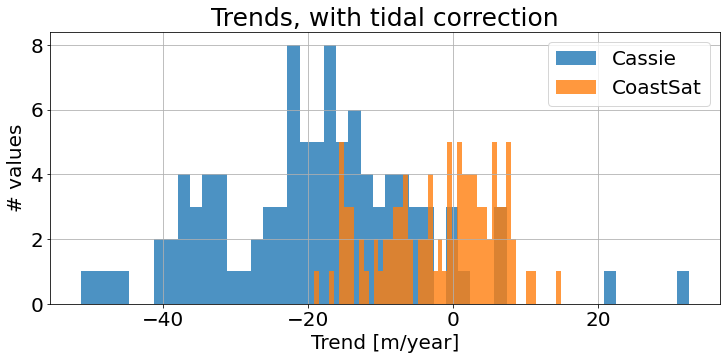

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(trend_cassie_tcorr, bins=50, label='Cassie', alpha=.8)
ax.hist(trend_cosat_tcorr, bins=50, label='CoastSat', alpha=.8)
ax.set_title('Trends, with tidal correction')
ax.set_xlabel('Trend [m/year]')
ax.set_ylabel('# values')
ax.legend()
ax.grid()

### Absolute differences

In [28]:
# CoastSat - Cassie (CoastSat interpolated to Cassie timestamps)
diff, diff_tcorr = [], []
for transect in cd_cosat_sm.keys():
    cosat_interp = np.interp(pd.to_datetime(sl_cassie_red_tides['dates']),
                   pd.to_datetime(sl_cosat_red_tides['dates']),
                   cd_cosat_sm[transect])
    cosat_corr_interp = np.interp(pd.to_datetime(sl_cassie_red_tides['dates']),
                   pd.to_datetime(sl_cosat_red_tides['dates']),
                   cd_cosat_tidalcorr_sm[transect])
    diff.append(cosat_interp - cd_cassie_sm[transect])
    diff_tcorr.append(cosat_corr_interp - cd_cassie_tidalcorr_sm[transect])

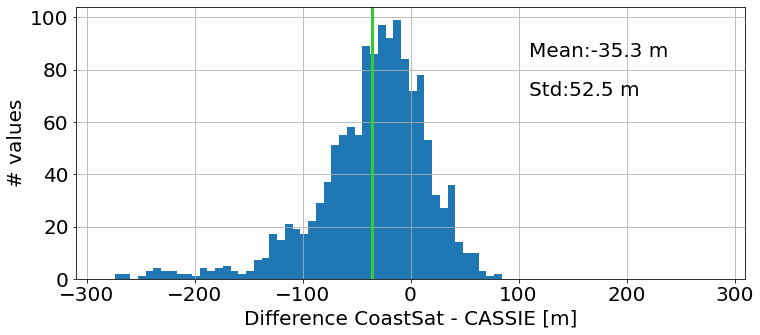

In [29]:
# Histogram of corrected values
# Put all values from the dictionary in one array
diff_corr_all = np.empty((0))
for x in diff_tcorr:
    vals_temp = x
    diff_corr_all = np.hstack((diff_corr_all, vals_temp))
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(diff_corr_all, bins=50)
ax.text(110,85,'Mean:'+str("%.1f" % round(np.nanmean(diff_corr_all),1)+' m'), fontsize=20)
ax.text(110,70,'Std:'+str("%.1f" % round(statistics.stdev(diff_corr_all[~np.isnan(diff_corr_all)]),1)+' m'), fontsize=20)
ax.axvline(np.nanmean(diff_corr_all), c='limegreen', lw=3)
# ax.set_title('CoastSat - CASSIE (tidally corrected), all differences')
ax.set_xlabel('Difference CoastSat - CASSIE [m]')
ax.set_ylabel('# values')
ax.set_xlim([-310, 310])
ax.grid()
plt.savefig('../99_plot_dump/coastsat_minus_cassie.png', dpi=300, bbox_inches='tight')

### Correlation

In [30]:
# CoastSat - Cassie (CoastSat interpolated to Cassie timestamps)
corr, corr_tcorr = [], []
for transect in cd_cosat_sm.keys():
    cosat_interp = np.interp(pd.to_datetime(sl_cassie_red_tides['dates']),
                   pd.to_datetime(sl_cosat_red_tides['dates']),
                   cd_cosat_sm[transect])
    cosat_corr_interp = np.interp(pd.to_datetime(sl_cassie_red_tides['dates']),
                   pd.to_datetime(sl_cosat_red_tides['dates']),
                   cd_cosat_tidalcorr_sm[transect])
    
    
    # Interpolate & extrapolate over nans
    cosat_interp = np.array(pd.Series(cosat_interp).interpolate().ffill().bfill())
    cosat_corr_interp = np.array(pd.Series(cosat_corr_interp).interpolate().ffill().bfill())
    cassie_uncorr_temp = np.array(pd.Series(cd_cassie_sm[transect]).interpolate().ffill().bfill())
    cassie_tcorr_temp = np.array(pd.Series(cd_cassie_tidalcorr_sm[transect]).interpolate().ffill().bfill())
    
    stack_uncorrected = np.vstack([cosat_interp, cassie_uncorr_temp])
    stack_tcorr = np.vstack([cosat_corr_interp, cassie_tcorr_temp])
        
    corr.append(np.corrcoef(stack_uncorrected)[0,1])
    corr_tcorr.append(np.corrcoef(stack_tcorr)[0,1])

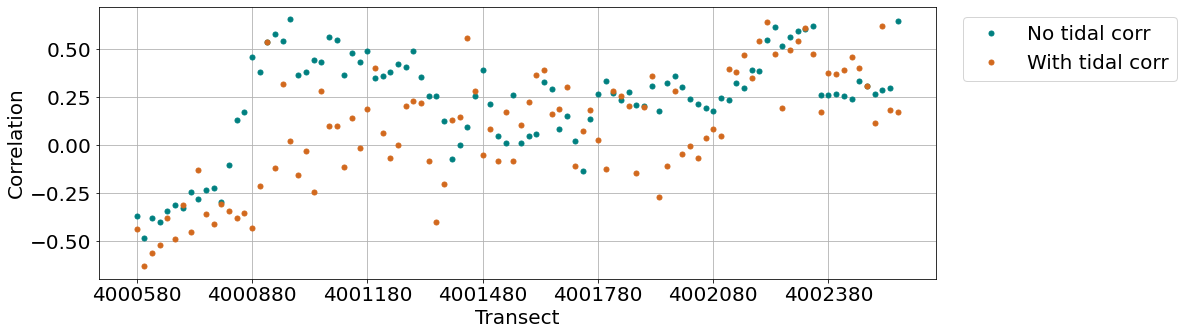

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cd_cassie_sm.keys(), corr, '.', label='No tidal corr', color='teal', markersize=10)
ax.plot(cd_cosat_sm.keys(), corr_tcorr, '.', label='With tidal corr', color='chocolate', markersize=10)
ax.legend(bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))
ax.set_ylabel('Correlation')
ax.set_xlabel('Transect')
xticks = list(cd_cassie_sm.keys())[0::15]
ax.set_xticks(xticks)
ax.grid()